In [45]:
import numpy as np
import pandas as pd


In [46]:
df = pd.read_csv('dataset\power-laws-forecasting-energy-consumption-training-data.csv')
df.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
0,4852050,42,2016-10-18T02:45:00+00:00,1087,26397.049623
1,1638923,42,2016-10-18T11:45:00+00:00,1087,42958.364641
2,5748910,42,2016-10-18T20:45:00+00:00,1087,27096.919666
3,38199,42,2016-10-20T10:45:00+00:00,1087,50211.408087
4,1338204,42,2016-10-20T18:45:00+00:00,1087,50503.305105


In [47]:
df_ts = df['Value']
df_ts = df_ts.fillna(df_ts.mean())
df_ts.isna().any()

False

In [48]:
df_ts = (df_ts-df_ts.mean())/df_ts.std()

In [49]:
def sigmoid(x):
    t = 1 + np.exp(-x)
    return (1/t)

In [59]:
df_ts[:99]

0    -0.001003
1    -0.000952
2    -0.001000
3    -0.000930
4    -0.000929
        ...   
94   -0.001025
95   -0.000924
96   -0.001009
97   -0.000925
98   -0.000917
Name: Value, Length: 99, dtype: float64

In [91]:
class LSTM():
    def __init__(self) -> None:
        # gates and states
        self.c = 0
        self.h = 0
        self.f = 0
        self.o = 0
        self.f = 0
        self.c_= 0
        self.prev_h = 0
        self.prev_c = 0
        #gradient array
        self.grad = []

        #weights
        #input gate
        self.wix = np.random.rand()
        self.wih = np.random.rand()
        self.bi = np.random.rand()
        self.wcx = np.random.rand()
        self.wch = np.random.rand()
        self.bc = np.random.rand()

        #forget gate 
        self.wfx = np.random.rand()
        self.wfh = np.random.rand()
        self.bf = np.random.rand()

        #output gate
        self.wox = np.random.rand()
        self.woh = np.random.rand()
        self.bo = np.random.rand()

    def forget_gate(self,x):
        f = self.wfx*x + self.wfh*self.h + self.bf
        return sigmoid(f)

    def input_gate(self,x):
        i = self.wix*x + self.wih*self.h + self.bi
        i = sigmoid(i)
        c_ = self.wcx*x + self.wch*self.h + self.bc
        c_ = np.tanh(c_)
        return i,c_

    def output_gate(self, x):
        o = self.wox*x + self.woh*self.h + self.bo
        return sigmoid(o)   
    
    def forward_pass(self,x):
        self.f = self.forget_gate(x) # % of long term mem to remember
        self.i,self.c_ = self.input_gate(x) # % and amount to input into long term mem
        self.prev_c = self.c
        self.c = self.f*self.c + self.i*self.c_  #forget and new input 
        self.o = self.output_gate(x)
        self.prev_h = self.h
        self.h = self.o*np.tanh(self.c) #update short term mem
        return self.h #output of LSTM for xt

    def get_gradients(self,y_pred,y,x):
        grad_dict = {}

        do = -(y-y_pred)*np.tanh(self.c)
        grad_dict['wox'] = do*self.o*(1-self.o)*x
        grad_dict['woh'] = do*self.o*(1-self.o)*self.prev_h
        grad_dict['bo'] = do*self.o*(1-self.o)

        di = -(y-y_pred)*self.o*(1-(np.tanh(self.c))**2)*self.c_
        grad_dict['wih'] = di*self.i*(1-self.i)*self.prev_h
        grad_dict['wix'] = di*self.i*(1-self.i)*x
        grad_dict['bi'] = di*self.i*(1-self.i)

        del_f = -(y-y_pred)*self.o*(1-(np.tanh(self.c))**2)*self.prev_c
        grad_dict['wfh'] = del_f*self.f*(1-self.f)*self.prev_h
        grad_dict['wfx'] = del_f*self.f*(1-self.f)*x
        grad_dict['bf'] = del_f*self.f*(1-self.f)

        dc_ = -(y-y_pred)*self.o*(1-(np.tanh(self.c))**2)*self.i
        grad_dict['wch'] = dc_*(1-self.c_**2)*self.prev_h
        grad_dict['wcx'] = dc_*(1-self.c_**2)*x
        grad_dict['bc'] = dc_*(1-self.c_**2)

        self.grad.append(grad_dict)
        return grad_dict
    def bptt(self,learning_rate):

        der = 0
        for d in self.grad:
            der += d['wih']
        self.wih = self.wih - learning_rate*der
        
        der = 0
        for d in self.grad:
            der += d['wix']
        self.wix = self.wix - learning_rate*der

        der = 0
        for d in self.grad:
            der += d['bi']
        self.bi = self.bi - learning_rate*der

        der = 0
        for d in self.grad:
            der += d['wfx']
        self.wfx = self.wfx - learning_rate*der

        der = 0
        for d in self.grad:
            der += d['wfh']
        self.wfh = self.wfh - learning_rate*der

        der = 0
        for d in self.grad:
            der += d['bf']
        self.bf = self.bf - learning_rate*der

        der = 0
        for d in self.grad:
            der += d['woh']
        self.woh = self.woh - learning_rate*der

        der = 0
        for d in self.grad:
            der += d['wox']
        self.wox = self.wox - learning_rate*der

        der = 0
        for d in self.grad:
            der += d['bo']
        self.bo = self.bo - learning_rate*der

        der = 0
        for d in self.grad:
            der += d['wch']
        self.wch = self.wch - learning_rate*der

        der = 0
        for d in self.grad:
            der += d['wcx']
        self.wcx = self.wcx - learning_rate*der

        der = 0
        for d in self.grad:
            der += d['bc']
        self.bc = self.bc - learning_rate*der

        #print(self.wih,self.wix,self.wfh,self.wfx,self.woh,self.wox,self.wcx,self.wch,self.bi,self.bf,self.bo,self.bc)


    def train(self,train_data,epochs,learning_rate = 0.0001):
        mse = []
        for i in range(epochs):
            for i in range(0,len(train_data)-1):
                y_pred = self.forward_pass(train_data[i])
                self.get_gradients(y_pred,train_data[i+1],train_data[i])

            # print(y_hat)               
            self.bptt(learning_rate)
            y_pred = self.forward_pass(train_data[len(train_data)-2])
            mse.append((y_pred-train_data[len(train_data)-1])**2)
        
        print(mse)
        return mse
        
    


In [92]:
model = LSTM()
mse = model.train(df_ts[:1000],200)

[0.6328700681837843, 0.6219925883127035, 0.604833642286501, 0.5809982152978055, 0.5500793624000793, 0.5118185382127529, 0.4663402500602799, 0.41443237245335285, 0.3577747370881966, 0.2989557951821407, 0.2411474348778359, 0.1874861207780852, 0.1404228117841398, 0.10133545398577913, 0.07050484244630383, 0.04734644893414302, 0.030736677945744365, 0.019326924116567796, 0.011792585135116248, 0.006991143294793458, 0.004028003223324084, 0.002252978379257825, 0.0012199810423945128, 0.0006364531858188492, 0.00031740292777315783, 0.00014945572027657097, 6.510435696734883e-05, 2.52958973895676e-05, 8.132075507483444e-06, 1.77112726694438e-06, 9.31504275167258e-08, 1.2395085303825057e-07, 5.469203346027434e-07, 8.706210886038616e-07, 9.80978259419506e-07, 9.123902789866621e-07, 7.390798012155728e-07, 5.29549652082353e-07, 3.3212465513694917e-07, 1.7434672462226156e-07, 6.743724326228617e-08, 1.1694194497747684e-08, 1.1385319467790127e-09, 2.6929271997947053e-08, 7.960052521111556e-08, 1.5036383210

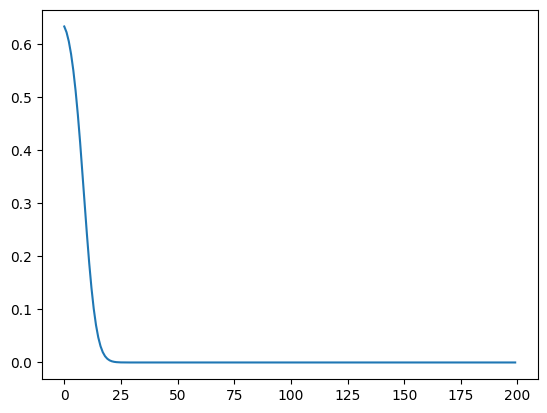

In [93]:
import matplotlib.pyplot as plt
array_list = [element for element in range(0,len(mse))]
plt.plot(array_list,mse)
plt.show()